<a href="https://colab.research.google.com/github/QasimWani/simple-transformer/blob/main/transformers/gpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Barebones implementation of GPT
# The goal is to test for overfitting. If we can overfit, at scale we can generalize.

import torch
import torch.nn as nn
import numpy as np
from einops import rearrange

from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.data import TensorDataset

from tqdm import tqdm
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd

# Model Definition

In [2]:
class SingleHeadedAttention(nn.Module):
  ''' Applies SHA with causal mask '''

  def __init__(self, max_seq_len, d_embed):
    super().__init__()

    self.q_proj = nn.Linear(d_embed, d_embed)
    self.k_proj = nn.Linear(d_embed, d_embed)
    self.v_proj = nn.Linear(d_embed, d_embed)

    self.w_out = nn.Sequential(
        nn.Linear(d_embed, d_embed),
        nn.Dropout(0.1)
    )

    self.attn_dropout = nn.Dropout(0.1)

    # Construct a one-time causal mask
    # max_seq_len, max_seq_len. Token at index i will only attend to tokens from 0 to i. This avoids learning from future positions
    mask = torch.triu(torch.ones(1, max_seq_len, max_seq_len), diagonal=1).bool()
    self.register_buffer('causal_mask', mask)

  def forward(self, x: torch.Tensor, pad_mask: torch.Tensor = None) -> torch.Tensor:
    batch_size, seq_len, d_embed = x.shape

    # Step 1. Project QKV
    Q = self.q_proj(x) # batch_size, seq_len, d_embed
    K = self.k_proj(x) # batch_size, seq_len, d_embed
    V = self.v_proj(x) # batch_size, seq_len, d_embed

    # Step 2. attention calculation
    scores = (Q @ K.transpose(-2, -1)) / (d_embed ** 0.5) # seq_len, d_embed x d_embed, seq_len -> batch_size, seq_len, seq_len (how different positions attend to each other)
    mask = self.causal_mask[:, :seq_len, :seq_len]

    if pad_mask is not None:
      # pad_mask.shape = batch_size, seq_len. 1 indicates real and 0 indicates <pad>
      pad_mask = pad_mask[:, None, :].bool() # batch_size, 1, seq_len
      combined_mask = mask | ~pad_mask
      scores = scores.masked_fill(combined_mask, float('-inf')) # no need to load to a particular device since model and x assumes same device
    else:
      scores = scores.masked_fill(mask, float('-inf')) # no need to load to a particular device since model and x assumes same device

    attention_weights = torch.softmax(scores, dim=-1) # batch_size, seq_len, seq_len. What happens if seq_len is very large? Lookup: Online Softmax
    attention_weights = self.attn_dropout(attention_weights)

    attention = attention_weights @ V # seq_len, seq_len x seq_len, d_embed -> batch_size, seq_len, d_embed relevance calculation

    out = self.w_out(attention) # batch_size, seq_len, d_embed
    return out # batch_size, seq_len, d_embed

In [3]:
class MultiHeadedAttention(nn.Module):
  ''' Applies MHA with causal mask '''
  def __init__(self, max_seq_len, d_embed, num_heads):
    super().__init__()

    assert d_embed % num_heads == 0, f"d_embed needs to be divisible by num_heads. Recommend parameters: d_embed = 768, num_heads = 12."

    self.qkv = nn.Linear(d_embed, d_embed * 3)
    self.w_out = nn.Sequential(
        nn.Linear(d_embed, d_embed),
        nn.Dropout(0.1)
    )

    self.attn_dropout = nn.Dropout(0.1)

    self.num_heads = num_heads
    self.head_dim = d_embed // num_heads

    # Register causal mask
    mask = torch.triu(torch.ones(1, 1, max_seq_len, max_seq_len, dtype=torch.bool), diagonal=1) # batch_size, num_heads, seq_len, seq_len
    self.register_buffer('causal_mask', mask)

  def forward(self, x: torch.Tensor, pad_mask: torch.Tensor = None) -> torch.Tensor:
    batch_size, seq_len, d_embed = x.shape

    # Step 1. Get QKV matrices, each has dimension of batch_size, seq_len, num_heads, head_dim
    qkv = self.qkv(x) # batch_size, seq_len, 3 * d_embed
    Q, K, V = rearrange(qkv,
                        'batch_size seq_len (three num_heads head_dim) -> three batch_size seq_len num_heads head_dim',
                        three=3,
                        num_heads=self.num_heads,
                        head_dim=self.head_dim).unbind(0) # Note: We do not need to explicitly unbind it since PyTorch uses the iterator to split across Q, K, V

    # Step 2. Compute Attention
    scores = torch.einsum('b q h d, b k h d -> b h q k', Q, K) / (self.head_dim ** 0.5) # batch_size, num_heads, seq_len, seq_len
    mask = self.causal_mask[..., :seq_len, :seq_len] # use elipses operator to keep the leading dimensions without defining them explicitly

    if pad_mask is not None:
        # Mask out pad tokens so real tokens don't attend to pad tokens.
        # This is called key pad. We don't want to pad query tokens because then we'll get an nan due to entire row being -inf
        # Pad rows still attend, but it's irrelevant because during loss we'll ignore them
        # For example, if we have an input: [cat sat on <pad> <pad>]
        # The causal mask would be:
        # [0 1 1 1 1] cat
        # [0 0 1 1 1] sat
        # [0 0 0 1 1] on
        # [0 0 0 0 1] <pad>
        # [0 0 0 0 0] <pad>
        # In this case, we are still attending to the last two columns. We need to explicitly set <pad> tokens to 1 so we mask it out.
        # Desired causal mask that includes masking pad tokens:
        #       cat   sat    on    <pad>    <pad>
        #  cat   0     1     1       1       1
        #  sat   0     0     1       1       1
        #  on    0     0     0       1       1
        #  <pad> 0     0     0       1       1
        #  <pad> 0     0     0       1       1
        # NOTE 1: For right-padded attention masks, you technically don't need to inject a pad mask since the causal mask will take care of the rest
        # NOTE 2: This is crucial to making batch inference work since you may have samples like:
        # 1 - [cat sat on  the]
        # 2 - [i   am  PAD PAD] <-- consistent shape required to pass into model forward pass
        # Output:
        # 1 - [cat sat on  the chair]
        # 2 - [i   am  PAD PAD crazy] <-- pad tokens have a score of 0 post softmax, which means attention weights = 0 which means dot product is 0 which means irrelevant
        pad_mask = pad_mask[:, None, None, :].bool() # # batch_size, 1, 1, seq_len
        combined_mask = mask | ~pad_mask
        scores = scores.masked_fill(combined_mask, float('-inf')) # broadcasts to batch_size, num_heads, seq_len, seq_len
    else:
        scores = scores.masked_fill(mask, float('-inf')) # broadcasts to batch_size, num_heads, seq_len, seq_len

    attention_weights = torch.softmax(scores, dim=-1) # batch_size, num_heads, seq_len, seq_len
    attention_weights = self.attn_dropout(attention_weights)

    attention = torch.einsum('b h q k, b k h d -> b q h d', attention_weights, V) # batch_size, seq_len, d_embed
    attention = rearrange(attention, 'b q h d -> b q (h d)')

    out = self.w_out(attention) # batch_size, seq_len, d_embed

    return out


In [4]:
class FFN(nn.Module):

  def __init__(self, in_channels, hidden_size, out_channels):
    super().__init__()
    self.network = nn.Sequential(
        nn.Linear(in_channels, hidden_size),
        nn.ReLU(), # Replace with GELU
        nn.Dropout(0.1),
        nn.Linear(hidden_size, out_channels),
        nn.Dropout(0.1)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.network(x)

In [5]:
class LayerNorm(nn.Module):

  def __init__(self, num_features, eps=1e-5):
    super().__init__()

    self.eps = eps
    self.gamma = nn.Parameter(torch.ones(num_features)) # d_embed
    self.beta = nn.Parameter(torch.zeros(num_features)) # d_embed


  def forward(self, x: torch.Tensor) -> torch.Tensor:
    batch_size, seq_len, d_embed = x.shape
    mu = x.mean(dim=-1, keepdim=True) # batch_size, seq_len, 1
    var = x.var(dim=-1, unbiased=False, keepdim=True) # batch_size, seq_len, 1. Note: unbiased = False divides by true population (instead of N - 1).
    # But for large enough d_embed, doesn't matter

    x = (x - mu) / torch.sqrt(var + self.eps) # batch_size, seq_len, d_embed
    return x * self.gamma + self.beta # automatic broadcasting: batch_size, seq_len, d_embed


In [6]:
class TransformerBlock(nn.Module):
  def __init__(self, max_seq_len, d_embed, num_heads):
    super().__init__()
    self.mha = MultiHeadedAttention(max_seq_len, d_embed, num_heads)
    self.ffn = FFN(d_embed, d_embed * 4, d_embed)

    self.ln1 = LayerNorm(d_embed)
    self.ln2 = LayerNorm(d_embed)

  def forward(self, x: torch.Tensor, pad_mask: torch.Tensor = None) -> torch.Tensor:
    x = x + self.mha(self.ln1(x), pad_mask) # Pre-norm
    x = x + self.ffn(self.ln2(x))
    return x


In [7]:
# Using Byte Tokenizer for simplicity, but I refer the reader to my in-depth implementation
# of several tokenizers here: https://github.com/QasimWani/simple-transformer/blob/main/transformers/tokenization.ipynb

class ByteTokenizer():
  vocab_size = 259

  def __init__(self):
    self.BOS_TOKEN = 256
    self.EOS_TOKEN = 257
    self.PAD_TOKEN = 258

  def encode(self, text: str):
    return [self.BOS_TOKEN] + list(text.encode('utf-8')) + [self.EOS_TOKEN]

  def decode(self, tokens):
    # for simplicity, we're injected token id = 256 for pad token. need to filter it out so prevent error for bytes(...) because a byte has range(0, 256)
    try:
      eos_idx = tokens.index(self.EOS_TOKEN)
      tokens = tokens[:eos_idx]
    except:
      # EOS not found, be careful might output jibberish
      pass

    # Filter out all special tokens
    tokens = [t for t in tokens if t < 256]
    return bytes(tokens).decode('utf-8')


In [8]:
class FixedPositionalEncodings(nn.Module):

  def __init__(self, max_seq_len, d_embed):
    super().__init__()
    assert d_embed % 2 == 0
    positional_encodings = torch.zeros(max_seq_len, d_embed) # max_seq_len, d_embed
    positions = rearrange(torch.arange(0, max_seq_len), 'seq_len->seq_len 1') # max_seq_len, 1
    # 1 / 10_000 ** (-index / d_embed) -or- exp(index * (-math.log(1e4) / d_embed))
    div_term = 1 / 10_000 ** (torch.arange(0, d_embed, 2) / d_embed) # d_embed // 2

    positional_encodings[..., 0::2] = torch.sin(positions * div_term) # max_seq_len, d_embed
    positional_encodings[..., 1::2] = torch.cos(positions * div_term) # max_seq_len, d_embed

    self.register_buffer('positions', positional_encodings)


  def forward(self, x: torch.Tensor) -> torch.Tensor:
    batch_size, seq_len, d_embed = x.shape
    return x + self.positions[:seq_len, :].unsqueeze(0) # batch_size, seq_len, d_embed

In [9]:
class GPT(nn.Module):

  def __init__(self, max_seq_len=512, d_embed=128, vocab_size=512, num_heads=4, num_transformer_blocks=8):
    super().__init__()

    self.config = {'max_seq_len': max_seq_len, 'd_embed': d_embed, 'vocab_size': vocab_size, 'num_heads': num_heads, 'num_transformer_blocks': num_transformer_blocks}

    self.transformer = nn.Sequential(*[TransformerBlock(max_seq_len, d_embed, num_heads) for _ in range(num_transformer_blocks)])
    self.add_positional_encodings = FixedPositionalEncodings(max_seq_len, d_embed)

    self.token_embeddings = nn.Embedding(vocab_size, d_embed) # We learn the representation to d_embed. Note: this is a giant lookup table.
    # You may ask yourself, learning a representation from large vocab_size of say 50,256 to small d_embed (766) is pretty challenging.
    # This is where the transformer network comes into play, whos main job is to learn this representation. So we keep this dead-simple weight preserving look-up table

    self.ln_final = LayerNorm(d_embed)
    self.lm_head = nn.Linear(d_embed, vocab_size, bias=False)
    self.lm_head.weight = self.token_embeddings.weight # NOTE: we do not need to transpose it because Linear layer will internally call: x @ W.T + b

  def forward(self, token_ids: torch.Tensor, pad_mask: torch.Tensor = None):
    # Step 1. tokenization
    token_embeddings = self.token_embeddings(token_ids) # batch_size, seq_len, d_embed

    # Step 2. apply positional embeddings
    embeddings = self.add_positional_encodings(token_embeddings) # batch_size, seq_len, d_embed (Fixed sinusoidal positions)

    # Step 3. Pass it through a transformer block
    for block in self.transformer:
      embeddings = block(embeddings, pad_mask) # you can't pass in two inputs to Sequential. So need to do it iteratively

    # Step 4. Pass it through final linear layer to project down to vocab size (seq_len, d_embed) -> (seq_len, vocab_size)
    out = self.lm_head(self.ln_final(embeddings)) # batch_size, seq_len, vocab_size

    return out

  def get_parameter_count(self):
    get_parameter_count = lambda param_name: sum(p.numel() for p in param_name.parameters())

    num_transformer_blocks = get_parameter_count(self.transformer)
    num_token_embeddings = get_parameter_count(self.token_embeddings)
    num_lm_head = get_parameter_count(self.lm_head)

    num_qkv_block = get_parameter_count(self.transformer[0].mha)
    num_ffn = get_parameter_count(self.transformer[0].ffn)
    num_layernorm = get_parameter_count(self.transformer[0].ln1) + get_parameter_count(self.transformer[0].ln2)

    num_final_ln = get_parameter_count(self.ln_final)

    # Get parameter count for transformer block
    return {
        'config': self.config,
        'transformer_blocks': num_transformer_blocks,
        'per_block_mha': num_qkv_block,
        'per_block_ffn': num_ffn,
        'per_block_layernorm': num_layernorm,
        'token_embeddings': num_token_embeddings,
        'final_ln': num_final_ln,
        'lm_head': num_lm_head, # NOTE: weight sharing, so we don't double count the parameters
        'total': num_transformer_blocks + num_token_embeddings + num_final_ln
    }


In [10]:
def get_top_p(logits: torch.Tensor, p: float, temperature: float, device: str, generator: torch._C.Generator = None):
  '''
  Nucleus sampling where the goal is to pick the smallest subset of logits that is greater than or equal to p
  Step 1. Sort logits
  Step 2. Convert to probabilities
  Step 3. Find the smallest subset s.t. the sum >= p
  Step 4. Retrieve the indices that belong to that subset
  '''
  batch_size, vocab_size = logits.shape

  if temperature <= 1e-8: # deterministic sampling
    return logits.argmax(dim=-1) # batch_size

  # Step 1. Sort logits
  sorted_logits, sorted_idx = (logits / temperature).sort(dim=-1, descending=True) # batch_size, vocab_size ; O(nlogn)

  # Step 2. Convert to probabilities
  sorted_probs = torch.softmax(sorted_logits, dim=-1) # batch_size, vocab_size. higher temperature more uniform aka random

  # Step 3. Find the smallest subset s.t. cdf ≥ p
  # Let's illustrate with an example
  # probs: [0.5, 0.3, 0.2] , p = 0.9
  # cumsum = [0.5, 0.8, 1.0] # Note: higher p leads to more uniform sampling while lower values of p leads to a more greedy sampling
  # mask (if current value less than p? if so, include that as part of sampling) = [True, True, False]. Only sample from index [0, 1]
  cdf = torch.cumsum(sorted_probs, dim=-1) # batch_size, vocab_size

  counts = (cdf < p).sum(dim=-1) + 1 # count-based indexing. shape: batch_size, k where k is in range(0, vocab_size)
  # NOTE: why not do just cdf <= p? Because the rule is that we need to find the smallest set that is greater than or equal to p.
  # Suppose you have cdf as [0.5, 0.8, 1.0] and p = 0.7
  # The smallest subset that is at greater than or equal to p=0.7 is [0.5, 0.8]. But if we did (cdf <= p) we'd get [0.5]

  # We now need to conver this into a mask because as it stands right now the tensor is imbalanced
  arange = torch.arange(0, vocab_size).unsqueeze(0).to(device) # (1, vocab_size) ; alternative do: torch.arange(0, vocab_size).expand(batch_size, vocab_size)
  mask = arange < counts.unsqueeze(-1) # batch_size, vocab_size

  top_probs = sorted_probs * mask.float()
  denom = top_probs.sum(dim=1, keepdim=True).clamp(min=1e-8)
  normalized_top_probs = top_probs / denom # batch_size, vocab_size

  # Sample from top probabilites. Note: because we make use of multinomial probabilities we do not need to worry about actually removing samples that are close to 0
  top_sample_indices = torch.multinomial(normalized_top_probs, num_samples=1, generator=generator) # batch_size, 1

  # Step 4. Retrieve the indices that belong to that subset

  # Because top_sample_indices is a position in normalized_top_probs we need to align it back to sorted_idx
  # Rule of thumb of when to use gather. X.shape = m, n and idx.shape = m. Use gather.
  token_id = torch.gather(sorted_idx, dim=1, index=top_sample_indices).squeeze(1) # batch_size
  return token_id # this represents the top token id since token index in range vocab_size is equivalent to the index it belongs to

# Model Train and Inference Logic

In [11]:
# Now, let's train the model

def train_one_epoch(dataloader, model, optimizer):
  model.train()
  criterion = nn.CrossEntropyLoss(ignore_index=-100, label_smoothing=0.05) # we will make the padding token id to be -100 s.t. we don't take that into account for loss calculation

  total_loss = 0.0
  total_correct_tokens = 0.0
  total_tokens = 0.0

  for batch in dataloader:
    optimizer.zero_grad()
    token_ids, attention_mask = batch

    logits = model(token_ids, attention_mask) # batch_size, seq_len, vocab_size

    # Loss calculation. Main idea is to shift by one.
    # Suppose current tokens that we feed into the model are [the cat sat]
    # The targets (just the tokens extended by one) would be: [cat sat on]. assume the original sequence is [the cat sat on the mat]
    # So at each step, we're just shifting the index by one so we explicitly teach the model to predict the next token
    targets = token_ids[:, 1:].clone() # batch_size, seq_len - 1 (start with the next token to ensure that the first token our model learns to predict is the second token in true sequence, first token in target)
    logits = logits[:, :-1, :] # batch_size, seq_len - 1, vocab_size
    mask_shifted = attention_mask[:, 1:] # batch_size, seq_len - 1
    targets[mask_shifted == 0] = -100 # make padded tokens -100

    loss = criterion(rearrange(logits, 'B T V -> (B T) V'), rearrange(targets, 'B T -> (B T)'))
    total_loss += loss.item()

    # Compute metrics
    predictions = torch.argmax(logits, dim=-1) # batch_size, seq_len - 1
    valid_mask = (targets != -100)
    correct = (targets == predictions) & valid_mask
    total_correct_tokens += correct.sum().item()
    total_tokens += valid_mask.sum().item()

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # MISSING
    optimizer.step()

  metrics = {
      'loss': total_loss / len(dataloader),
      'perplexity': np.exp(total_loss / len(dataloader)),
      'accuracy': total_correct_tokens / total_tokens if total_tokens > 0 else 0,
      'total_correct_tokens': total_correct_tokens,
      'total_tokens': total_tokens
      }
  return metrics

@torch.inference_mode()
def validate(dataloader, model):
  model.eval()
  metrics = {'loss': 0.0, 'perplexity': 0, 'accuracy': 0, 'total_correct_tokens': 0, 'total_tokens': 0}
  criterion = nn.CrossEntropyLoss(ignore_index=-100)

  for token_ids, attn_mask in dataloader: # batch_size, seq_len
    logits = model(token_ids, attn_mask)[:, :-1, :] # batch_size, seq_len - 1, vocab_size

    # Shift by one
    # input: [cat (sat on the)]. Full sequence = [cat sat on the fridge eating a candy]
    # model pred: [(sat on the wall) eatibsa]

    mask_shifted = attn_mask[:, 1:]
    targets = token_ids[:, 1:].clone()
    targets[mask_shifted == 0] = -100

    # Compute metrics
    predictions = torch.argmax(logits, dim=-1) # batch_size, seq_len -1
    valid_mask = (targets != -100)
    correct = (targets == predictions) & valid_mask

    # Convert to correct shape
    targets = rearrange(targets, 'B T -> (B T)')
    logits = rearrange(logits, 'B T V -> (B T) V')

    loss = criterion(logits, targets)

    # Log metrics
    metrics['loss'] += loss.item()
    metrics['total_correct_tokens'] += correct.sum().item()
    metrics['total_tokens'] += valid_mask.sum().item()

  metrics['loss'] /= len(dataloader)
  metrics['perplexity'] = np.exp(metrics['loss'])
  metrics['accuracy'] = metrics['total_correct_tokens'] / metrics['total_tokens'] if metrics['total_tokens'] > 0 else 0

  return metrics


@torch.inference_mode()
def run_inference(model, prompt, max_seq_len = 1024, p=0.7, temperature=0.01, device='cuda'):
  model.eval()
  tokenizer = ByteTokenizer()
  token_ids = tokenizer.encode(prompt)[:-1] # remove EOS token that's automatically added at the end
  tokens_generated = 0

  # print(f"Number of tokens in prompt: {len(token_ids)}.\tToken budget: {max_seq_len - len(token_ids)}")

  while len(token_ids) < max_seq_len:
    tokens = torch.tensor(token_ids, device=device).unsqueeze(0) # batch_size, seq_len
    logits = model(tokens) # batch_size, seq_len, vocab_size
    pred = logits[:, -1, :] # 1, vocab_size
    next_token = get_top_p(pred, p=p, temperature=temperature, device=device) # single value
    token_ids.append(next_token.item())
    tokens_generated += 1

    # Stope at EOS token
    if next_token.item() == tokenizer.EOS_TOKEN:
      # print(f"Terminated early at position {tokens_generated}")
      break

  return {
      'tokens_generated': tokens_generated,
      'tokens': token_ids,
      'text': tokenizer.decode(token_ids)
  }



# Batch inference
@torch.inference_mode()
def batch_inference(model, prompts, max_seq_len, p=0.7, temperature=0.01, device="cuda"):
    '''
    Let's motivate the problem with the following example of a padded causal mask (1 = ignore, 0 = keep):
                  cat  sat   on  <PAD>  <PAD>
      1 -  cat     0    1    1    1      1
      2 -  sat     0    0    1    1      1
      3 -  on      0    0    0    1      1
      4 -  <pad>   0    0    0    1      1
      5 -  <pad>   0    0    0    1      1

    For rows 1 thru 3, the next token is conditioned on a real token. But for row 4 and 5,
    the model will attend to cat, sat, and on. This is problematic because pad token is garbage value and
    we should not condition the model to output the next token on a garbage logit as it will produce a
    nonsensical result. Decoding from that as the previous value is like asking a model "what comes
    next after a sequence with PAD at the end?" which doesn't make sense.
    Instead, we should keep track of position of where the last real-token was and
    use that position as the pointer of where to generate the next token from.

    NOTE: We can not mask out queries (rows) because it will throw an NaN error post softmax. So we need
    to handle the logic ourselves.

    Step 1. Generate a full sequence
    Step 2. Put real tokens on the left
    Step 3. Generate next tokens and keep track of valid mask and cursor position
    '''
    model.eval() # reduce variance caused by dropout

    batch_size = len(prompts)

    tokenizer = ByteTokenizer()

    encoded_prompts = [tokenizer.encode(p)[:-1][:max_seq_len] for p in prompts] # remove EOS token

    batched_tokens = torch.full((batch_size, max_seq_len), tokenizer.PAD_TOKEN, device=device) # batch_size, max_seq_len
    # Left-fill real tokens
    for i, e in enumerate(encoded_prompts):
      batched_tokens[i, :len(e)] = torch.tensor(e, device=device)

    valid_mask = torch.ones(batch_size, device=device).bool()
    cursor = torch.tensor([len(e) for e in encoded_prompts], device=device) # batch_size. Each element dictates the position of last real token

    shortest_encoded_sequence = min(len(e) for e in encoded_prompts) # gets the position of the shortest last real token

    for t in range(shortest_encoded_sequence, max_seq_len):
      active_indices = valid_mask.nonzero(as_tuple=True)[0] # gets the indices of all valid (1) elements
      if len(active_indices) == 0: # all sequences have terminated
        break

      x = batched_tokens[active_indices].to(device) # valid_batch, seq_len
      attn_mask = (x != tokenizer.PAD_TOKEN) # 1 = Real. 0 = PAD
      logits_all = model(x, attn_mask) # valid_batch, seq_len, vocab_size

      # now, we apply the cursor
      curr = cursor[active_indices] - 1 # will return the token in last position

      logits = logits_all[torch.arange(len(active_indices), device=device), curr, :] # valid_batch, vocab_size
      # Question: why do we need to do arange(active_indices)?
      # Answer: If we don't pytorch will broadcast. We basically want to take the subset of all active-indices
      # and then from that list extract all curr values (this is how we get the final shape to be batch_size, vocab_size)
      # as opposed to batch_size, seq_len, vocab_size
      next_tokens = get_top_p(logits, p=p, temperature=temperature, device=device) # valid_batch

      # Update logic
      eos_mask = (next_tokens == tokenizer.EOS_TOKEN) # EOS mask
      at_limit = (cursor[active_indices] >= max_seq_len - 1) # have any of my sequences hit max. limit
      should_terminate = eos_mask | at_limit

      valid_mask[active_indices[should_terminate]] = False
      batched_tokens[active_indices, cursor[active_indices]] = next_tokens # valid_batch
      cursor[active_indices[~should_terminate]] += 1 # update cursor for non EOS/last entry sequences


    return {
        'batched_tokens': batched_tokens.tolist(),
        'batched_text': [tokenizer.decode(b[:c]) for b, c in zip(batched_tokens.tolist(), cursor.tolist())]
    }


# Data construction and pick optimal context window

In [12]:
# Simple dataset construction

def dataset_construction(data: list[str], max_seq_len, batch_size, device) -> TensorDataset:
  input_ids_list = []
  attn_mask_list = []
  tokenizer = ByteTokenizer()

  batch_size = min(batch_size, len(data))

  for sample in data:
    tokens = tokenizer.encode(sample)

    if len(tokens) > max_seq_len:
      # add bos and eos token, truncate the sequence to match max_seq_len
      tokens = [tokenizer.BOS_TOKEN] + tokens[1: max_seq_len - 1] + [tokenizer.EOS_TOKEN]

    # create attention mask (1 for real tokens and 0 for pad tokens)
    attn_mask = torch.where(torch.arange(max_seq_len) < len(tokens), 1, 0).tolist()
    tokens = tokens + [tokenizer.PAD_TOKEN] * (max_seq_len - len(tokens))

    input_ids_list.append(torch.tensor(tokens))
    attn_mask_list.append(torch.tensor(attn_mask))

  # Stack into tensor
  input_ids_list = torch.stack(input_ids_list, dim=0).to(device)
  attn_mask_list = torch.stack(attn_mask_list, dim=0).to(device)
  ds = TensorDataset(input_ids_list, attn_mask_list)

  print(f"Dataset size: {len(ds)} x {max_seq_len}. Number of true tokens: {attn_mask_list.sum()}. "
  f"Total token count: {len(ds) * max_seq_len}. Ratio: {round(attn_mask_list.sum().item() / (len(ds) * max_seq_len), 3)}")

  return DataLoader(ds, batch_size=batch_size, shuffle=True)


In [13]:
def analyze_length_distribution(texts):
    tokenizer = ByteTokenizer()
    lengths = [len(tokenizer.encode(text)) for text in texts]

    print(f"Mean length: {np.mean(lengths):.1f}")
    print(f"95th percentile: {np.percentile(lengths, 95):.1f}")
    print(f"99th percentile: {np.percentile(lengths, 99):.1f}")

    # Choose seq_len to capture 90-95% of your data
    optimal_seq_len = int(np.percentile(lengths, 95))
    return optimal_seq_len

In [14]:
# List of Charles Bukowski quotes
train_quotes = [
    "Some people never go crazy. What truly horrible lives they must lead.",
    "Do you hate people? I don't hate them...I just feel better when they're not around.",
    "For those who believe in God, most of the big questions are answered. But for those of us who can't readily accept the God formula, the big answers don't remain stone-written. We adjust to new conditions and discoveries. We are pliable. Love need not be a command nor faith a dictum. I am my own god. We are here to unlearn the teachings of the church, state, and our educational system. We are here to drink beer. We are here to kill war. We are here to laugh at the odds and live our lives so well that Death will tremble to take us.",
    "Sometimes you climb out of bed in the morning and you think, I'm not going to make it, but you laugh inside — remembering all the times you've felt that way.",
    "I've never been lonely. I've been in a room -- I've felt suicidal. I've been depressed. I've felt awful -- awful beyond all -- but I never felt that one other person could enter that room and cure what was bothering me...or that any number of people could enter that room. In other words, loneliness is something I've never been bothered with because I've always had this terrible itch for solitude. It's being at a party, or at a stadium full of people cheering for something, that I might feel loneliness. I'll quote Ibsen, \"The strongest men are the most alone.\" I've never thought, \"Well, some beautiful blonde will come in here and give me a fuck-job, rub my balls, and I'll feel good.\" No, that won't help. You know the typical crowd, \"Wow, it's Friday night, what are you going to do? Just sit there?\" Well, yeah. Because there's nothing out there. It's stupidity. Stupid people mingling with stupid people. Let them stupidify themselves. I've never been bothered with the need to rush out into the night.",
    "If you're going to try, go all the way. Otherwise, don't even start. This could mean losing girlfriends, wives, relatives and maybe even your mind. It could mean not eating for three or four days. It could mean freezing on a park bench. It could mean jail. It could mean derision. It could mean mockery--isolation. Isolation is the gift. All the others are a test of your endurance, of how much you really want to do it. And, you'll do it, despite rejection and the worst odds. And it will be better than anything else you can imagine. If you're going to try, go all the way. There is no other feeling like that. You will be alone with the gods, and the nights will flame with fire. You will ride life straight to perfect laughter. It's the only good fight there is.",
    "We're all going to die, all of us, what a circus! That alone should make us love each other but it doesn't. We are terrorized and flattened by trivialities, we are eaten up by nothing.",
    "what matters most is how well you walk through the fire",
    "The problem with the world is that the intelligent people are full of doubts, while the stupid ones are full of confidence.",
    "You have to die a few times before you can really live.",
    "My ambition is handicapped by laziness",
    "That's the problem with drinking, I thought, as I poured myself a drink. If something bad happens you drink in an attempt to forget; if something good happens you drink in order to celebrate; and if nothing happens you drink to make something happen.",
    "there is a loneliness in this world so great that you can see it in the slow movement of the hands of a clock. people so tired mutilated either by love or no love. people just are not good to each other one on one. the rich are not good to the rich the poor are not good to the poor. we are afraid. our educational system tells us that we can all be big-ass winners. it hasn't told us about the gutters or the suicides. or the terror of one person aching in one place alone untouched unspoken to watering a plant.",
    "I wanted the whole world or nothing.",
    "Find what you love and let it kill you.",
    "An intellectual says a simple thing in a hard way. An artist says a hard thing in a simple way.",
    "there are worse things than being alone but it often takes decades to realize this and most often when you do it's too late and there's nothing worse than too late",
    "If you're losing your soul and you know it, then you've still got a soul left to lose",
    "Some lose all mind and become soul, insane. some lose all soul and become mind, intellectual. some lose both and become accepted",
    "I loved you like a man loves a woman he never touches, only writes to, keeps little photographs of.",
    "Real loneliness is not necessarily limited to when you are alone."
    "Nothing can save you except writing. It keeps the walls from falling.",
    "Find what you love and let it kill you. Let it drain you of your all. Let it cling onto your back and weigh you down into eventual nothingness. Let it kill you and let it devour your remains. For all things will kill you, both slowly and fastly, but it's much better to be killed by a lover.",
    "The problem with the world is that the intelligent people are full of doubts, while the stupid ones are full of confidence.",
    "Poetry is what happens when nothing else can.",
    "There's a light somewhere. It may not be much light but it beats the darkness.",
    "She's mad but she's magic. There's no lie in her fire.",
    "I will always carry you inside, outside, on my fingertips and at brain edges and in centers, centers of what I am of what remains.",
    "We are strong enough to live and to die and to kill flies, attend the boxing matches, go to the racetrack, live on luck and skill, get alone, get alone often.",
    "Time is meant to be wasted, love fails and death is useless.",
    "When God created love he didn't help most. When God created dogs He didn't help dogs.",
    "How in the hell could a man enjoy being awakened at 6:30 a.m. by an alarm clock, leap out of bed, dress, force-feed, shit, piss, brush teeth and hair, and fight traffic to get to a place where essentially you made lots of money for somebody else and were asked to be grateful for the opportunity to do so?",
    "Some moments are nice, some are nicer, some are even worth writing about.",
    "I never met another man I'd rather be. And even if that's a delusion, it's a lucky one.",
    "Genius might be the ability to say a profound thing in a simple way.",
    "Censorship is the tool of those who have the need to hide actualities from themselves and from others.",
    "The difference between a democracy and a dictatorship is that in a democracy you vote first and take orders later; in a dictatorship you don't have to waste your time voting.",
    "I do not like the human race. I don't like their heads, I don't like their faces, I don't like their feet, I don't like their conversations, I don't like their hairdos, I don't like their automobiles.",
    "Almost everybody is born a genius and buried an idiot.",
    "If you want to know who your friends are, get yourself a jail sentence.",
    "Having a bunch of cats around is good.",
    "Oh, I don't mean you're handsome, not the way people think of handsome. Your face seems kind. But your eyes - they're beautiful. They're wild, crazy, like some animal peering out of a forest on fire.",
    "I wasn't a misanthrope and I wasn't a misogynist but I liked being alone. It felt good to sit alone in a small space and smoke and drink. I had always been good company for myself.",
    "I wasn't lonely. I was just caught up in a life in which I could find no meaning.",
    "I like desperate men, men with broken teeth and broken minds and broken ways. They interest me. They are full of surprises and explosions.",
    "Show me an old poet, and I'll show you, more often than not, either a madman or a master.",
    "It's when you begin to lie to yourself in a poem in order simply to make a poem that you fail.",
    "We are here to laugh at the odds and live our lives so well that Death will tremble to take us.",
    "In a capitalistic society the losers slaved for the winners and you have to have more losers than winners.",
    "That's your answer to everything: drink. No, that's my answer to nothing.",
    "There is a loneliness in this world so great that you can see it in the slow movement of the hands of a clock.",
    "The terror is always there, man. The ugliness is always there. There's no way out.",
    "You're always going to be burned. There's never any pleasantness, easiness anywhere.",
    "Poetry is what happens when nothing else can.",
    "There's a light somewhere. It may not be much light but it beats the darkness.",
    "The strongest men are the most alone.",
    "I hid in bars, because I didn't want to hide in factories.",
    "Stupid people mingling with stupid people. Let them stupidify themselves.",
    "I've never been bothered with the need to rush out into the night.",
    "I'm the best form of entertainment I have.",
    "Isolation is the gift. All the others are a test of your endurance.",
    "You will ride life straight to perfect laughter. It's the only good fight there is.",
    "We are terrorized and flattened by trivialities, we are eaten up by nothing.",
    "Your face seems kind. But your eyes - they're beautiful. They're wild, crazy.",
    "I also like vile women, drunk cursing bitches with loose stockings and sloppy mascara faces.",
    "I'm more interested in perverts than saints. I can relax with bums because I am a bum.",
    "I don't like laws, morals, religions, rules. I don't like to be shaped by society.",
    "Some lose both and become: accepted.",
    "There's no way I would welcome the intolerable dull senseless hell you would bring me.",
    "I wish you luck in bed and out but not in mine.",
    "You can get a beautiful woman living with you and she can be more ugly than putting your quarter into a newspaper stand.",
    "There's never any escape from anything at all.",
    "No matter how much you know, no matter how much you feel, you're gonna be burnt.",
    "When you open a cap on a mustard jar you're gonna be burnt.",
    "The flesh covers the bone and they put a mind in there and sometimes a soul, and the women break vases against the walls and the men drink too much and nobody finds the one but they keep looking crawling in and out of beds.",
    "You're gonna be burnt down to the gutter.", # Fake quote
    "You're gonna be burnt up to the gutter.", # Fake quote
    "Love need not be a command nor faith a dictum.",
    "Fight for what is possible within yourself, so that your life and your death will not be like theirs.", # Duplicate
    "Isn't it funny how you can ache just from the deadly drone of existence?", # Duplicate
    "It takes a lifetime to die and no time at all.", # Duplicate
    "The free soul is rare, but you know it when you see it - basically because you feel good, very good, when you are near or with them.", # Duplicate
    "We are here to unlearn the teachings of the church, state, and our educational system.", # Duplicate
]

test_quotes = [
    "Fight for what is possible within yourself, so that your life and your death will not be like theirs.",
    "Isn't it funny how you can ache just from the deadly drone of existence?",
    "You're gonna be burnt down to the grave.",
    "It takes a lifetime to die and no time at all.",
    "The free soul is rare, but you know it when you see it - basically because you feel good, very good, when you are near or with them.",
    "We are here to unlearn the teachings of the church, state, and our educational system.",
    "We are here to drink beer. We are here to kill war.",
    "Death will tremble to take us.",
    "The free soul is rare, but you know it when you see it.",
    "If you're losing your soul and you know it, then you've still got a soul left to lose.",
    "Some people never believe that old relationships can be revived and made new again. But please if you feel that way don't phone don't write don't arrive.",
    "Nobody ever finds the one. The city dumps fill the junkyards fill the madhouses fill the hospitals fill the graveyards fill nothing else fills.",
    "There's a bluebird in my heart that wants to get out but I'm too tough for him.",
    "We ask for no mercy or no miracles; we are strong enough to live and to die."
]

In [15]:
device = 'cuda'
MAX_SEQ_LEN = analyze_length_distribution(train_quotes)

train_dl = dataset_construction(train_quotes, max_seq_len=MAX_SEQ_LEN, batch_size=4, device=device)
test_dl = dataset_construction(test_quotes, max_seq_len=MAX_SEQ_LEN, batch_size=4, device=device)

Mean length: 128.5
95th percentile: 306.3
99th percentile: 814.7
Dataset size: 82 x 306. Number of true tokens: 8923. Total token count: 25092. Ratio: 0.356
Dataset size: 14 x 306. Number of true tokens: 1178. Total token count: 4284. Ratio: 0.275


In [16]:
model = GPT(max_seq_len=MAX_SEQ_LEN, d_embed=128, vocab_size=ByteTokenizer.vocab_size, num_heads=8, num_transformer_blocks=2).to(device)
# Nice illustrations showcasing scaling laws:
# 1. Parameter count: https://claude.ai/public/artifacts/af13cc77-c008-4436-b61c-129d4e9c66f2
# 2. FLOPs: screenshot at https://youtu.be/SQ3fZ1sAqXI?si=dnzKwbDe9ArzvfFz&t=334

for k, v in model.get_parameter_count().items():
  if k != 'config':
    print(f"{k} : {v:_}")
  else:
    print(f"{k} : {v}")

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# Clear cuda cache
torch.cuda.empty_cache()

config : {'max_seq_len': 306, 'd_embed': 128, 'vocab_size': 259, 'num_heads': 8, 'num_transformer_blocks': 2}
transformer_blocks : 396_544
per_block_mha : 66_048
per_block_ffn : 131_712
per_block_layernorm : 512
token_embeddings : 33_152
final_ln : 256
lm_head : 33_152
total : 429_952


In [17]:
%%time

NUM_EPOCHS = 250
metrics = defaultdict(list)
for _ in tqdm(range(NUM_EPOCHS)):
  l = train_one_epoch(train_dl, model, optimizer)
  m = validate(test_dl, model)
  for k, v in m.items():
    metrics[f"test_{k}"].append(v)

  for k, v in l.items():
    metrics[f"train_{k}"].append(v)


100%|██████████| 250/250 [01:00<00:00,  4.14it/s]

CPU times: user 56.4 s, sys: 569 ms, total: 56.9 s
Wall time: 1min


Best Test PPL: 5.47
Best Train PPL: 2.03
Best Test accuracy: 0.65


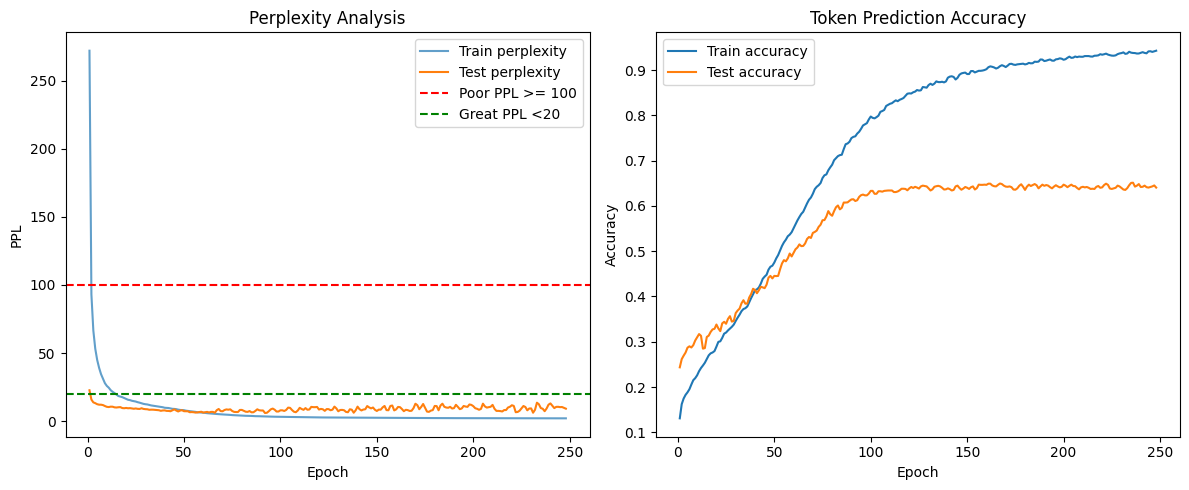

In [18]:
print("Best Test PPL:", round(min(metrics['test_perplexity']), 2))
print("Best Train PPL:", round(min(metrics['train_perplexity']), 2))
print("Best Test accuracy:", round(max(metrics['test_accuracy']), 2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left subplot - PPL analysis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('PPL')
ax1.plot(pd.Series(metrics['train_perplexity'][1:]).rolling(window=2).mean().to_list(), label='Train perplexity', alpha=0.7)
ax1.plot(pd.Series(metrics['test_perplexity'][1:]).rolling(window=2).mean().to_list(), label='Test perplexity')
ax1.axhline(y=100, color='r', linestyle='--', label='Poor PPL >= 100')
ax1.axhline(y=20, color='g', linestyle='--', label='Great PPL <20')
ax1.legend()
ax1.set_title('Perplexity Analysis')

# Right subplot - Accuracy
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.plot(pd.Series(metrics['train_accuracy'][1:]).rolling(window=2).mean().to_list(), label='Train accuracy')
ax2.plot(pd.Series(metrics['test_accuracy'][1:]).rolling(window=2).mean().to_list(), label='Test accuracy')
ax2.legend()
ax2.set_title('Token Prediction Accuracy')

plt.tight_layout()
plt.show()

# Analysis of Batch vs. Sequential Inference

In [19]:
%%time

import time
# High temperature is more random
# Low temperature is more determinisitc

# High p is sample from more tokens - random
# Low p is sample from fewer tokens - greedy

# Calculate total sequential time
st = time.time()
batched_prompts = []
sequential_outputs = []
for t in train_quotes[:40]:
  idx = np.random.randint(3, len(t) // 4) # initial prompt will be up to 25% of original string
  out = run_inference(model, t[:idx], device='cuda', max_seq_len=MAX_SEQ_LEN, p=0.5, temperature=0)
  batched_prompts.append(t[:idx])
  sequential_outputs.append(out['tokens'])

sequential_total_time_taken = time.time() - st

# Calculate total batch time
st = time.time()
with torch.no_grad():
  batched_outputs = batch_inference(model, batched_prompts, max_seq_len=MAX_SEQ_LEN, p=0.5, temperature=0, device='cuda')['batched_tokens']
batched_total_time_taken = time.time() - st

CPU times: user 11.5 s, sys: 43.2 ms, total: 11.6 s
Wall time: 14.8 s


In [20]:
import difflib

def seq_similarity(sequential_outputs: list[list[int]], batched_output: list[list[int]]) -> float:
    tokenizer = ByteTokenizer()
    return round(np.mean([difflib.SequenceMatcher(None, tokenizer.decode(seq), tokenizer.decode(batch)).ratio() for seq, batch in zip(sequential_outputs, batched_output)]), 2)

assert seq_similarity(sequential_outputs, batched_outputs) == 1.0, f"Batched and Sequential sequences produce diverging results"

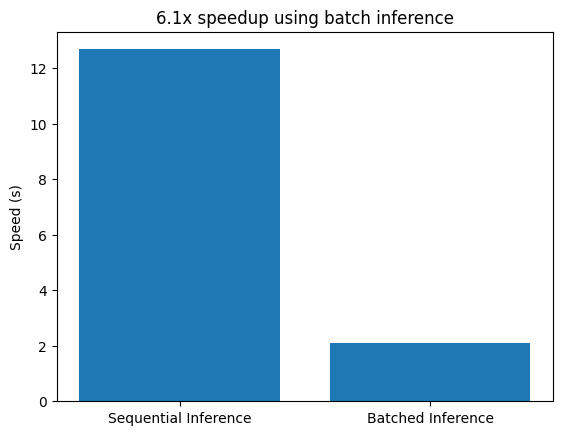

In [21]:
speedup = round(sequential_total_time_taken / batched_total_time_taken, 1)
plt.title(f"{speedup}x speedup using batch inference")
plt.xticks(np.arange(2), ['Sequential Inference', 'Batched Inference'])
plt.bar(np.arange(2), [sequential_total_time_taken, batched_total_time_taken])
plt.ylabel('Speed (s)')
plt.show()